# Sparkify Project

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat,count, desc, explode, lit, min, max, split, stddev, udf, when, isnan, from_unixtime
from pyspark.sql.types import IntegerType, LongType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, GBTClassifier, RandomForestClassifier, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy.special import boxcox1p

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import re

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify_mini") \
    .getOrCreate()

# Load and Clean Dataset

In [3]:
log = spark.read.json("mini_sparkify_event_data.json")

In [4]:
log.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [5]:
log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
log.createOrReplaceTempView("log_table")

In [7]:
print("The length of the data is: {}.".format(log.count()))

The length of the data is: 286500.


In [8]:
spark.sql('''
    SELECT
        gender,
        COUNT(DISTINCT userId) as count
    FROM
        log_table
    GROUP BY gender
''').show()

+------+-----+
|gender|count|
+------+-----+
|     F|  104|
|  null|    1|
|     M|  121|
+------+-----+



## Understanding missing values

In [9]:
print('These are the NaN values')
log.select([count(when(isnan(feat), feat)).alias(feat) for feat in log.columns]).show()

These are the NaN values
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [10]:
print('These are the Null values')
log.select([count(when(col(feat).isNull(), feat)).alias(feat) for feat in log.columns]).show()

These are the Null values
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [11]:
print("These are the '' values")
log.select([count(when((log[feat] == ""), feat)).alias(feat) for feat in log.columns]).show()

These are the '' values
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|  8346|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



**From the above we can see that there are only '' values in the userId. The count of it, 8346, is equal to the count of Null values for: userAgent, registration, location, lastName, gender and firstName. This leads to the conclusion that these Null values might be due to the userId itself, or at least they are all correlated.**

Let's check some of it.

In [12]:
spark.sql('''
    SELECT
        userId,
        firstName,
        lastName,
        gender,
        location,
        registration,
        auth,
        level,
        sessionId,
        method,
        artist
    FROM
        log_table
    WHERE userId = '' 
''').show(5)

+------+---------+--------+------+--------+------------+----------+-----+---------+------+------+
|userId|firstName|lastName|gender|location|registration|      auth|level|sessionId|method|artist|
+------+---------+--------+------+--------+------------+----------+-----+---------+------+------+
|      |     null|    null|  null|    null|        null|Logged Out| free|        8|   GET|  null|
|      |     null|    null|  null|    null|        null|Logged Out| free|        8|   GET|  null|
|      |     null|    null|  null|    null|        null|Logged Out| free|        8|   GET|  null|
|      |     null|    null|  null|    null|        null|Logged Out| free|        8|   PUT|  null|
|      |     null|    null|  null|    null|        null|Logged Out| free|      240|   GET|  null|
+------+---------+--------+------+--------+------------+----------+-----+---------+------+------+
only showing top 5 rows



**It seems that it is indeed the case. Moreover, as depicted by the artist feature, some other null values can also be correlated to this phenomenum. It seems to be a good idea to remove any row with userId = ''.**

### Removing userId's with ''

In [13]:
log_cleaned = log.where(log.userId != '')

print("{} rows removed due to userId = ''.".format(log.count() - log_cleaned.count()))

8346 rows removed due to userId = ''.


**Checking for Null values now.**

In [14]:
print('These are amount the Null values now')
log_cleaned.select([count(when(col(feat).isNull(), feat)).alias(feat) for feat in log_cleaned.columns]).show()

These are amount the Null values now
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 50046|   0|        0|     0|            0|       0| 50046|    0|       0|     0|   0|           0|        0|50046|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



**Changing gender to numeric values; 1 for female, 0 for male**.

In [15]:
log_cleaned = log_cleaned.replace(['F','M'],['1','0'],'gender')
log_cleaned = log_cleaned.withColumn("gender", log_cleaned["gender"].cast(IntegerType()))

**Changing level to numeric values; 1 for paid, 0 for free.**

In [16]:
log_cleaned = log_cleaned.replace(["free", "paid"], ["0", "1"], "level")
log_cleaned = log_cleaned.withColumn("level", log_cleaned["level"].cast(IntegerType()))

**Features such as firstName and lastName should be removed.**

In [17]:
log_cleaned = log_cleaned.select('userId','artist','auth','gender','itemInSession','length','level','location','method','page',
                                'registration','sessionId','song','status','ts','userAgent')

### Defining Churn

In [18]:
log_cleaned.createOrReplaceTempView("log_table")

In [19]:
churned_users = spark.sql('''
    SELECT 
        DISTINCT userId, 
        1 as churn 
    FROM
        log_table 
    WHERE page = 'Cancellation Confirmation'
''')

churned_users.show(5)

+------+-----+
|userId|churn|
+------+-----+
|100005|    1|
|300007|    1|
|100011|    1|
|100012|    1|
|   101|    1|
+------+-----+
only showing top 5 rows



In [20]:
didnt_churn = spark.sql('''
    SELECT
        DISTINCT userId, 
        0 as churn 
    FROM 
        log_table
    WHERE userId NOT IN (
                        SELECT 
                            DISTINCT userId 
                        FROM 
                            log_table 
                        WHERE page = 'Cancellation Confirmation'
                        )
''')

didnt_churn.show(5)

+------+-----+
|userId|churn|
+------+-----+
|    19|    0|
|200007|    0|
|    50|    0|
|200002|    0|
|    30|    0|
+------+-----+
only showing top 5 rows



In [21]:
comb_churn = didnt_churn.union(churned_users)

In [22]:
comb_churn.createOrReplaceTempView("churn_table")

In [23]:
spark.sql('''
    SELECT 
        *
    FROM
        churn_table
    ORDER BY RAND()
''').show(5)

+------+-----+
|userId|churn|
+------+-----+
|300009|    0|
|100003|    1|
|100016|    0|
|   100|    0|
|200010|    0|
+------+-----+
only showing top 5 rows



In [24]:
spark.sql('''
    SELECT 
        churn,
        COUNT(churn)
    FROM
        churn_table
    GROUP BY churn
''').show(5)

+-----+------------+
|churn|count(churn)|
+-----+------------+
|    1|          52|
|    0|         173|
+-----+------------+



In [25]:
comb_churn.count()

225

### Getting time right

In [26]:
log_cleaned.createOrReplaceTempView("log_table")

In [27]:
timing = udf(lambda x: x//1000, IntegerType())
log_cleaned = log_cleaned.withColumn("adj_ts", from_unixtime(timing('ts')))
log_cleaned = log_cleaned.withColumn("adj_reg", from_unixtime(timing('registration')))

log_cleaned.head()

Row(userId='30', artist='Martha Tilston', auth='Logged In', gender=0, itemInSession=50, length=277.89016, level=1, location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', adj_ts='2018-09-30 21:01:57', adj_reg='2018-09-28 19:22:42')

**Now we can drop 'ts' and 'registration'**

In [28]:
log_cleaned = log_cleaned.select('userId','artist','auth','gender','itemInSession','length','level','location','method','page',
                                'adj_reg','sessionId','song','status','adj_ts','userAgent')

## Exploratory Data Analysis

In [29]:
log_cleaned.createOrReplaceTempView("log_table")

In [30]:
spark.sql('''
    SELECT
        DISTINCT location
    FROM
        log_table
    LIMIT 5
''').show()

+--------------------+
|            location|
+--------------------+
|     Gainesville, FL|
|Atlantic City-Ham...|
|Deltona-Daytona B...|
|San Diego-Carlsba...|
|Cleveland-Elyria, OH|
+--------------------+



In [31]:
spark.sql('''
    SELECT
        DISTINCT page
    FROM
        log_table
    ORDER BY page
''').show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [32]:
spark.sql('''
    SELECT
        level,
        COUNT(DISTINCT userId)
    FROM
        log_table
    GROUP BY level
''').show(5)

+-----+----------------------+
|level|count(DISTINCT userId)|
+-----+----------------------+
|    1|                   165|
|    0|                   195|
+-----+----------------------+



In [33]:
spark.sql('''
    SELECT
        location,
        COUNT(location) AS count_loc
    FROM
        log_table
    GROUP BY location
    ORDER BY count_loc DESC
''').show(5)

+--------------------+---------+
|            location|count_loc|
+--------------------+---------+
|Los Angeles-Long ...|    30131|
|New York-Newark-J...|    23684|
|Boston-Cambridge-...|    13873|
|Houston-The Woodl...|     9499|
|Charlotte-Concord...|     7780|
+--------------------+---------+
only showing top 5 rows



In [34]:
spark.sql('''
    SELECT
        COUNT(DISTINCT location)
    FROM
        log_table
''').show(5)

+------------------------+
|count(DISTINCT location)|
+------------------------+
|                     114|
+------------------------+



In [35]:
spark.sql('''
    SELECT
        DISTINCT method
    FROM
        log_table
''').show(5)

+------+
|method|
+------+
|   PUT|
|   GET|
+------+



In [36]:
spark.sql('''
    SELECT
        DISTINCT sessionId
    FROM
        log_table
    ORDER BY sessionId
''').show(5)

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
+---------+
only showing top 5 rows



In [37]:
spark.sql('''
    SELECT
        userId,
        sessionId,
        page,
        status,
        song
    FROM
        log_table
    WHERE sessionId = 31
''').show(10)

+------+---------+-----------+------+--------------------+
|userId|sessionId|       page|status|                song|
+------+---------+-----------+------+--------------------+
|100010|       31|   NextSong|   200|Captain Tyin Knot...|
|100010|       31|   NextSong|   200|Beautiful_ Beauti...|
|100010|       31|   NextSong|   200|          She's Gone|
|100010|       31|  Thumbs Up|   307|                null|
|100010|       31|   NextSong|   200|      Folk Bloodbath|
|100010|       31|   NextSong|   200|                 Yes|
|100010|       31|   NextSong|   200|             Secrets|
|100010|       31|   NextSong|   200|      You're The One|
|100010|       31|Roll Advert|   200|                null|
|100010|       31|   NextSong|   200|          Mr Sandman|
+------+---------+-----------+------+--------------------+
only showing top 10 rows



In [38]:
spark.sql('''
    SELECT
        COUNT(DISTINCT userId) as num_userid,
        sessionId
    FROM
        log_table
    GROUP BY sessionId
    ORDER BY num_userid DESC
''').show(5)

+----------+---------+
|num_userid|sessionId|
+----------+---------+
|         4|      113|
|         4|      167|
|         4|      112|
|         4|       54|
|         4|       65|
+----------+---------+
only showing top 5 rows



In [39]:
spark.sql('''
    SELECT
        *
    FROM
        log_table
    WHERE status != 200
''').show(5)

+------+------+---------+------+-------------+------+-----+--------------------+------+-----------+-------------------+---------+----+------+-------------------+--------------------+
|userId|artist|     auth|gender|itemInSession|length|level|            location|method|       page|            adj_reg|sessionId|song|status|             adj_ts|           userAgent|
+------+------+---------+------+-------------+------+-----+--------------------+------+-----------+-------------------+---------+----+------+-------------------+--------------------+
|     9|  null|Logged In|     0|           86|  null|    0|Boston-Cambridge-...|   PUT|  Thumbs Up|2018-09-30 15:20:30|        8|null|   307|2018-09-30 21:22:56|"Mozilla/5.0 (Win...|
|    54|  null|Logged In|     1|            7|  null|    1|Spokane-Spokane V...|   PUT|  Thumbs Up|2018-07-24 22:37:42|       53|null|   307|2018-09-30 21:54:15|Mozilla/5.0 (Wind...|
|     9|  null|Logged In|     0|           95|  null|    0|Boston-Cambridge-...|   PU

In [40]:
spark.sql('''
    SELECT
        DISTINCT status
    FROM
        log_table
''').show(5)

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



In [41]:
spark.sql('''
    SELECT
        DISTINCT auth
    FROM
        log_table
''').show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



In [42]:
spark.sql('''
    SELECT
        DISTINCT userAgent
    FROM
        log_table
''').show(5)

+--------------------+
|           userAgent|
+--------------------+
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (X11;...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
+--------------------+
only showing top 5 rows



In [43]:
spark.sql('''
    SELECT
        DISTINCT itemInSession
    FROM
        log_table
''').show(10)

+-------------+
|itemInSession|
+-------------+
|           26|
|           29|
|          474|
|          964|
|           65|
|          191|
|          418|
|          541|
|          558|
|         1010|
+-------------+
only showing top 10 rows



### getting user location (state) 

In [44]:
us_state = udf(lambda x: x[-2:])
log_cleaned = log_cleaned.withColumn('US_state', us_state('location'))
log_cleaned.head()

Row(userId='30', artist='Martha Tilston', auth='Logged In', gender=0, itemInSession=50, length=277.89016, level=1, location='Bakersfield, CA', method='PUT', page='NextSong', adj_reg='2018-09-28 19:22:42', sessionId=29, song='Rockpools', status=200, adj_ts='2018-09-30 21:01:57', userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', US_state='CA')

In [45]:
log_cleaned.createOrReplaceTempView("log_table")

In [46]:
spark.sql('''
    SELECT 
        userId, 
        COUNT(DISTINCT US_state) AS count_state
    FROM
        log_table 
    GROUP BY userId 
    ORDER BY count_state DESC
''').show(5)

+------+-----------+
|userId|count_state|
+------+-----------+
|   125|          1|
|    11|          1|
|   101|          1|
|200002|          1|
|100010|          1|
+------+-----------+
only showing top 5 rows



**From the cell above, we can see that each user is observed only in a single state**

# Feature Engineering

### 1. Number of songs listened per days as an user

In [47]:
num_songs = spark.sql('''
    SELECT
        userId,
        COUNT(page) / DATEDIFF(MAX(adj_ts),adj_reg)  as num_songs
    FROM
        log_table
    WHERE page = 'NextSong'
    GROUP BY userID, adj_reg
''')

### 2. Number of friends added  per days as an user

In [48]:
friends_added = spark.sql('''
    SELECT
        userId,
        COUNT(page) / DATEDIFF(MAX(adj_ts),adj_reg) as friends_added
    FROM
        log_table
    WHERE page = 'Add Friend'
    GROUP BY userID, adj_reg
''')

### 3. Gender of user

In [49]:
user_gender = spark.sql('''
    SELECT
        DISTINCT userId,
        gender 
    FROM
        log_table
''')

### 4. Number of sessions per days as an user

In [50]:
num_sessions = spark.sql('''
    SELECT
        userId,
        COUNT(sessionId) / DATEDIFF(MAX(adj_ts),adj_reg) AS num_sessions 
    FROM
        log_table
    GROUP BY userId, adj_reg
''')

### 5. total time listenning per days as an user

In [51]:
sum_length = spark.sql('''
    SELECT
        userId,
        SUM(length) / DATEDIFF(MAX(adj_ts),adj_reg) AS sum_length 
    FROM
        log_table
    GROUP BY userId, adj_reg
''')

### 6. Level of user

Since the users might have 1 out of 2 different levels depending on the time, I will take the maximum levelthe user has ever had.

In [52]:
user_level = spark.sql('''
    SELECT
        userId,
        MAX(level) AS level
    FROM
        log_table
    GROUP BY userId
''')

### 7. Number of songs added to playlist per days as an user

In [53]:
playlist_add = spark.sql('''
    SELECT
        userId,
        COUNT(page) / DATEDIFF(MAX(adj_ts),adj_reg) as playlist_add
    FROM
        log_table
    WHERE page = 'Add to Playlist'
    GROUP BY userID, adj_reg
''')

### 8. Has the user submitted downgrade? 

In [54]:
downgraded = spark.sql('''
    SELECT
        userId,
        COUNT(page) as downgraded
    FROM
        log_table
    WHERE page = 'Submit Downgrade'
    GROUP BY userID
''')

In [55]:
didnt_downgrade = spark.sql('''
    SELECT
        DISTINCT userId, 
        0 as downgraded 
    FROM 
        log_table
    WHERE userId NOT IN (
                        SELECT 
                            DISTINCT userId 
                        FROM 
                            log_table 
                        WHERE page = 'Submit Downgrade'
                        )
''')

In [56]:
didnt_downgrade.count()

176

In [57]:
didnt_downgrade.count() + downgraded.count()

225

In [58]:
num_downgrade = didnt_downgrade.union(downgraded)

### 9. User location (state) 

In [59]:
user_loc = spark.sql('''
    SELECT
        DISTINCT userId,
        US_state as user_loc 
    FROM
        log_table
''')

### 10. Number of days as an user 

In [60]:
num_days = spark.sql('''
    SELECT
        userId,
        DATEDIFF(MAX(adj_ts),adj_reg) AS num_days
    FROM
        log_table
    GROUP BY userId, adj_reg
    ORDER BY num_days DESC
''')

### 11. Number of errors occured per days as an user

In [61]:
num_errors = spark.sql('''
    SELECT
        userId,
        COUNT(page) / DATEDIFF(MAX(adj_ts),adj_reg) as num_errors
    FROM
        log_table
    WHERE page = 'Error'
    GROUP BY userID, adj_reg
''')

### 12. Number of help events per days as an user

In [62]:
num_helps = spark.sql('''
    SELECT
        userId,
        COUNT(page) / DATEDIFF(MAX(adj_ts),adj_reg) as num_helps
    FROM
        log_table
    WHERE page = 'Help'
    GROUP BY userID, adj_reg
''')

### 13. Number of Logouts per days as an user

In [63]:
num_logouts = spark.sql('''
    SELECT
        userId,
        COUNT(page) / DATEDIFF(MAX(adj_ts),adj_reg) as num_logouts
    FROM
        log_table
    WHERE page = 'Logout'
    GROUP BY userID, adj_reg
''')

### 14. Number of Roll Adverts per days as an user

In [64]:
num_rolladvert = spark.sql('''
    SELECT
        userId,
        COUNT(page) / DATEDIFF(MAX(adj_ts),adj_reg) as num_rolladvert
    FROM
        log_table
    WHERE page = 'Roll Advert'
    GROUP BY userID, adj_reg
''')

### 15. Number of Save Settings per days as an user

In [65]:
num_savesettings = spark.sql('''
    SELECT
        userId,
        COUNT(page) / DATEDIFF(MAX(adj_ts),adj_reg) as num_savesettings
    FROM
        log_table
    WHERE page = 'Save Settings'
    GROUP BY userID, adj_reg
''')

### 16. Number of Thumbs Down per days as an user

In [66]:
num_thumbsdown = spark.sql('''
    SELECT
        userId,
        COUNT(page) / DATEDIFF(MAX(adj_ts),adj_reg) as num_thumbsdown
    FROM
        log_table
    WHERE page = 'Thumbs Down'
    GROUP BY userID, adj_reg
''')

### 17. Number of Thumbs Up per days as an user

In [67]:
num_thumbsup = spark.sql('''
    SELECT
        userId,
        COUNT(page) / DATEDIFF(MAX(adj_ts),adj_reg) as num_thumbsup
    FROM
        log_table
    WHERE page = 'Thumbs Up'
    GROUP BY userID, adj_reg
''')

### 18. Number of Submit Upgrade

In [68]:
upgraded = spark.sql('''
    SELECT
        userId,
        COUNT(page) as upgraded
    FROM
        log_table
    WHERE page = 'Submit Upgrade'
    GROUP BY userID
''')

In [69]:
didnt_upgrade = spark.sql('''
    SELECT
        DISTINCT userId, 
        0 as upgraded 
    FROM 
        log_table
    WHERE userId NOT IN (
                        SELECT 
                            DISTINCT userId 
                        FROM 
                            log_table 
                        WHERE page = 'Submit Upgrade'
                        )
''')

In [70]:
didnt_upgrade.count()

94

In [71]:
didnt_upgrade.count() + upgraded.count()

225

In [72]:
num_upgrade = didnt_upgrade.union(upgraded)

### 19. Num of status 404 per days as an user

In [73]:
num_status404 = spark.sql('''
    SELECT
        userId,
        COUNT(status) / DATEDIFF(MAX(adj_ts),adj_reg) as num_status404
    FROM
        log_table
    WHERE status = 404
    GROUP BY userID, adj_reg
''')

### Joining data 

In [74]:
all_data = comb_churn \
    .join(user_gender,'userId','outer') \
    .join(user_level,'userId','outer') \
    .join(num_downgrade,'userId','outer') \
    .join(playlist_add,'userId','outer') \
    .join(num_sessions,'userId','outer') \
    .join(sum_length,'userId','outer') \
    .join(num_songs,'userId','outer') \
    .join(num_days,'userId','outer') \
    .join(num_errors,'userId','outer') \
    .join(num_helps,'userId','outer') \
    .join(num_logouts,'userId','outer') \
    .join(num_rolladvert,'userId','outer') \
    .join(num_savesettings,'userId','outer') \
    .join(num_thumbsdown,'userId','outer') \
    .join(num_thumbsup,'userId','outer') \
    .join(num_upgrade,'userId','outer') \
    .join(num_status404,'userId','outer') \
    .join(friends_added,'userId','outer') \
    .drop('userId') \
    .fillna(0)
# Here I fill Null values with 0, because some of the users will have null values for not having any, e.g., error events.

In [75]:
all_data = all_data.select(*[col(s).alias('label') if s == 'churn' else s for s in all_data.columns])

### Separating into training and test data

Here I separate the traning and test data, so we avoid bias. The following analysis will only be done on the training data

In [76]:
# Split in a stratified manner

zeros = all_data.filter(all_data["label"]==0)
ones = all_data.filter(all_data["label"]==1)

train0, test0 = zeros.randomSplit([0.8,0.2], seed=42)
train1, test1 = ones.randomSplit([0.8,0.2], seed=42)

all_data = train0.union(train1)
test = test0.union(test1)

### Graphic EDA

#### Usage by state

In [77]:
log_cleaned.createOrReplaceTempView("log_table")

In [78]:
usage_by_state = spark.sql('''
    SELECT
        COUNT(page) / COUNT(DISTINCT userId) as interactions,
        US_state
    FROM
        log_table
    GROUP BY US_state
    ORDER BY interactions DESC
''').toPandas()

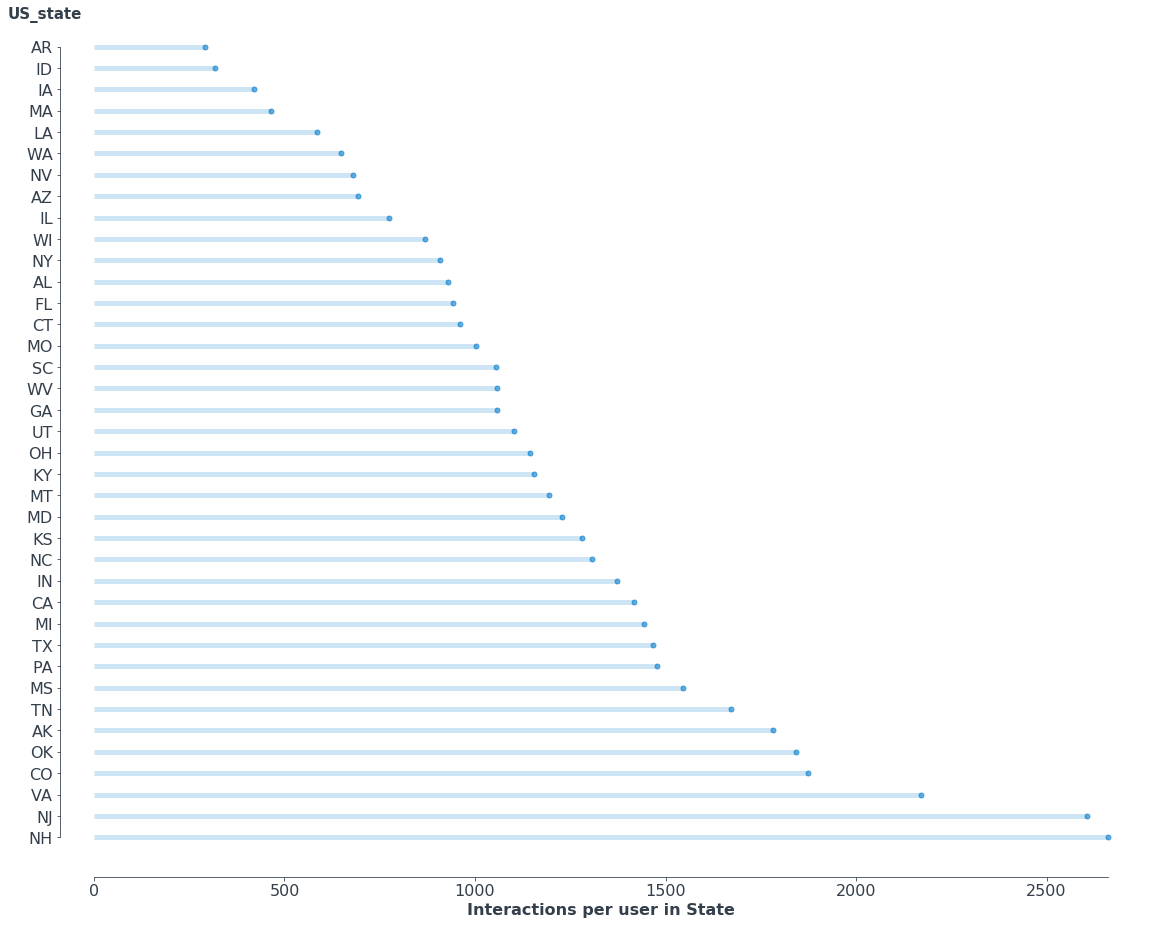

In [79]:
"""
Making bar plots beautiful
I've used the code from https://scentellegher.github.io/visualization/2018/10/10/beautiful-bar-plots-matplotlib.html
as a basis for this plot.
"""

# set font
plt.rcParams['font.family'] = 'DeJaVu Sans'
plt.rcParams['font.sans-serif'] = 'Helvetica'

# set the style of the axes and the text color
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['text.color']='#333F4B'

# we first need a numeric placeholder for the y axis
my_range=list(range(1,len(usage_by_state.index)))

fig, ax = plt.subplots(figsize=(10*2,8*2))

# create for each expense type an horizontal line that starts at x = 0 with the length 
# represented by the specific expense percentage value.
plt.hlines(y=my_range, xmin=0, xmax=usage_by_state['interactions'][:-1], color='#007ACC', alpha=0.2, linewidth=5)

# create for each expense type a dot at the level of the expense percentage value
plt.plot(usage_by_state['interactions'][:-1], my_range, "o", markersize=5, color='#007ACC', alpha=0.6)

# set labels
ax.set_xlabel('Interactions per user in State', fontsize=16, fontweight='black', color = '#333F4B')
ax.set_ylabel('')

# set axis
ax.tick_params(axis='both', which='major', labelsize=16)
plt.yticks(my_range, usage_by_state['US_state'])

# add an horizonal label for the y axis 
fig.text(0.1, 0.87, 'US_state', fontsize=15, fontweight='black', color = '#333F4B')

# change the style of the axis spines
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)

# set the spines position
ax.spines['bottom'].set_position(('axes', -0.0))
ax.spines['left'].set_position(('axes', 0.015))
# plt.savefig(r'C:\Users\hnbez\Documents\GitHub\Portfolio_under_construction\Sparkify/USstate_pageCount.png',bbox_inches="tight")

#### Churns vs state

In [80]:
Churns_per_state = spark.sql('''
    SELECT 
        COUNT(page) as churn,
        US_state
    FROM 
        log_table 
    WHERE page = 'Cancellation Confirmation' 
    GROUP BY US_state
''')

In [81]:
users_per_state = spark.sql('''
    SELECT
        COUNT(DISTINCT userId) as users,
        US_state
    FROM 
        log_table 
    GROUP BY US_state
''')

In [82]:
churns_per_user_in_state = Churns_per_state.join(users_per_state,'US_state','outer').fillna(0)

In [83]:
churns_per_user_in_state.createOrReplaceTempView("churn_user_table")

In [84]:
Churns_by_state = spark.sql('''
    SELECT
        US_state,
        ROUND(churn / users, 3)*100 AS Churns
    FROM
        churn_user_table
    ORDER BY Churns DESC
''').toPandas()

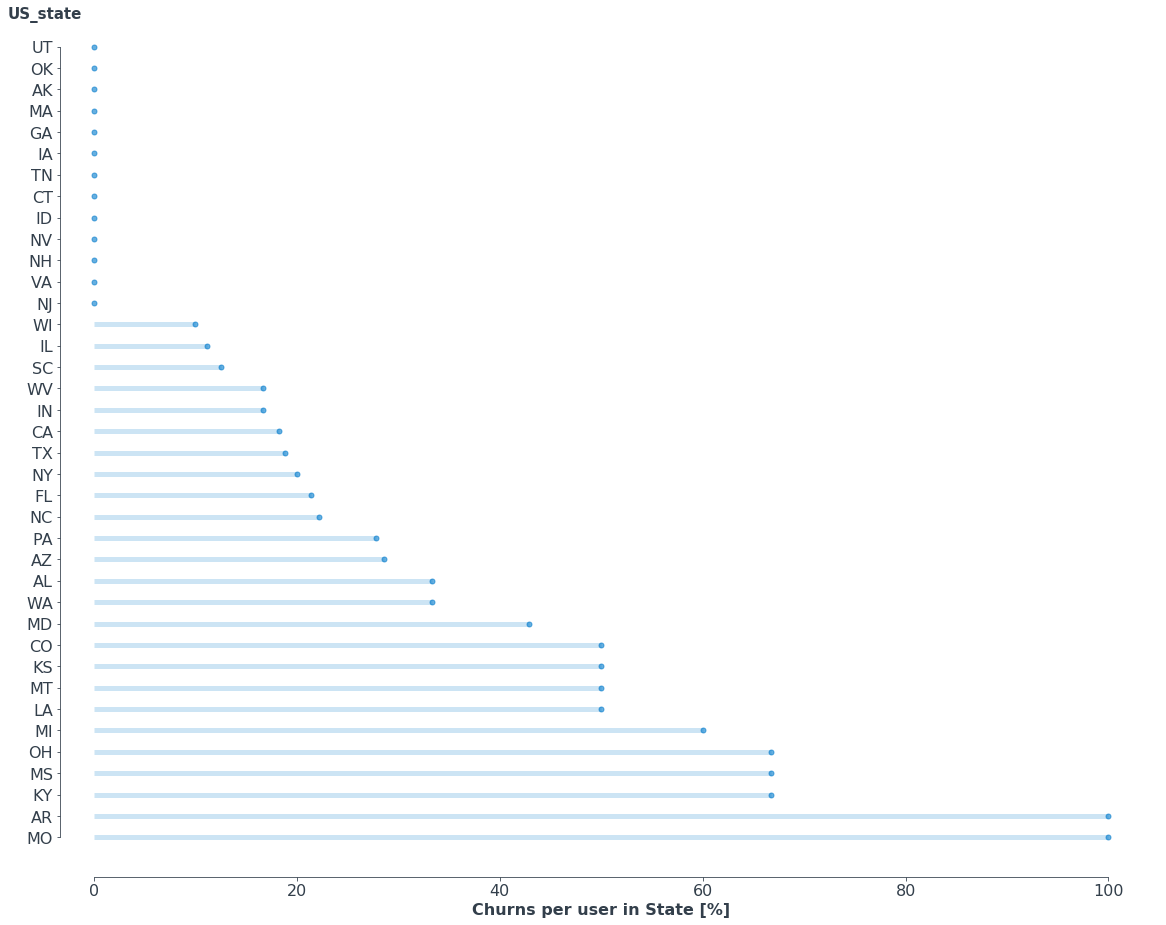

In [85]:
"""
Making bar plots beautiful
I've used the code from https://scentellegher.github.io/visualization/2018/10/10/beautiful-bar-plots-matplotlib.html
as a basis for this plot.
"""

# set font
plt.rcParams['font.family'] = 'DeJaVu Sans'
plt.rcParams['font.sans-serif'] = 'Helvetica'

# set the style of the axes and the text color
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['text.color']='#333F4B'

# we first need a numeric placeholder for the y axis
my_range=list(range(1,len(Churns_by_state.index)))

fig, ax = plt.subplots(figsize=(10*2,8*2))

# create for each expense type an horizontal line that starts at x = 0 with the length 
# represented by the specific expense percentage value.
plt.hlines(y=my_range, xmin=0, xmax=Churns_by_state['Churns'][1:], color='#007ACC', alpha=0.2, linewidth=5)

# create for each expense type a dot at the level of the expense percentage value
plt.plot(Churns_by_state['Churns'][1:], my_range, "o", markersize=5, color='#007ACC', alpha=0.6)

# set labels
ax.set_xlabel('Churns per user in State [%]', fontsize=16, fontweight='black', color = '#333F4B')
ax.set_ylabel('')

# set axis
ax.tick_params(axis='both', which='major', labelsize=16)
plt.yticks(my_range, Churns_by_state['US_state'][1:])

# add an horizonal label for the y axis 
fig.text(0.1, 0.87, 'US_state', fontsize=15, fontweight='black', color = '#333F4B')

# change the style of the axis spines
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)

# set the spines position
ax.spines['bottom'].set_position(('axes', -0.0))
ax.spines['left'].set_position(('axes', 0.015))
# plt.savefig(r'C:\Users\hnbez\Documents\GitHub\Portfolio_under_construction\Sparkify/Churns_per_state.png',bbox_inches="tight")

#### Users per state

In [86]:
users_per_state_pd = users_per_state.toPandas()

In [87]:
users_per_state_pd = users_per_state_pd.sort_values(['users'],ascending=False)

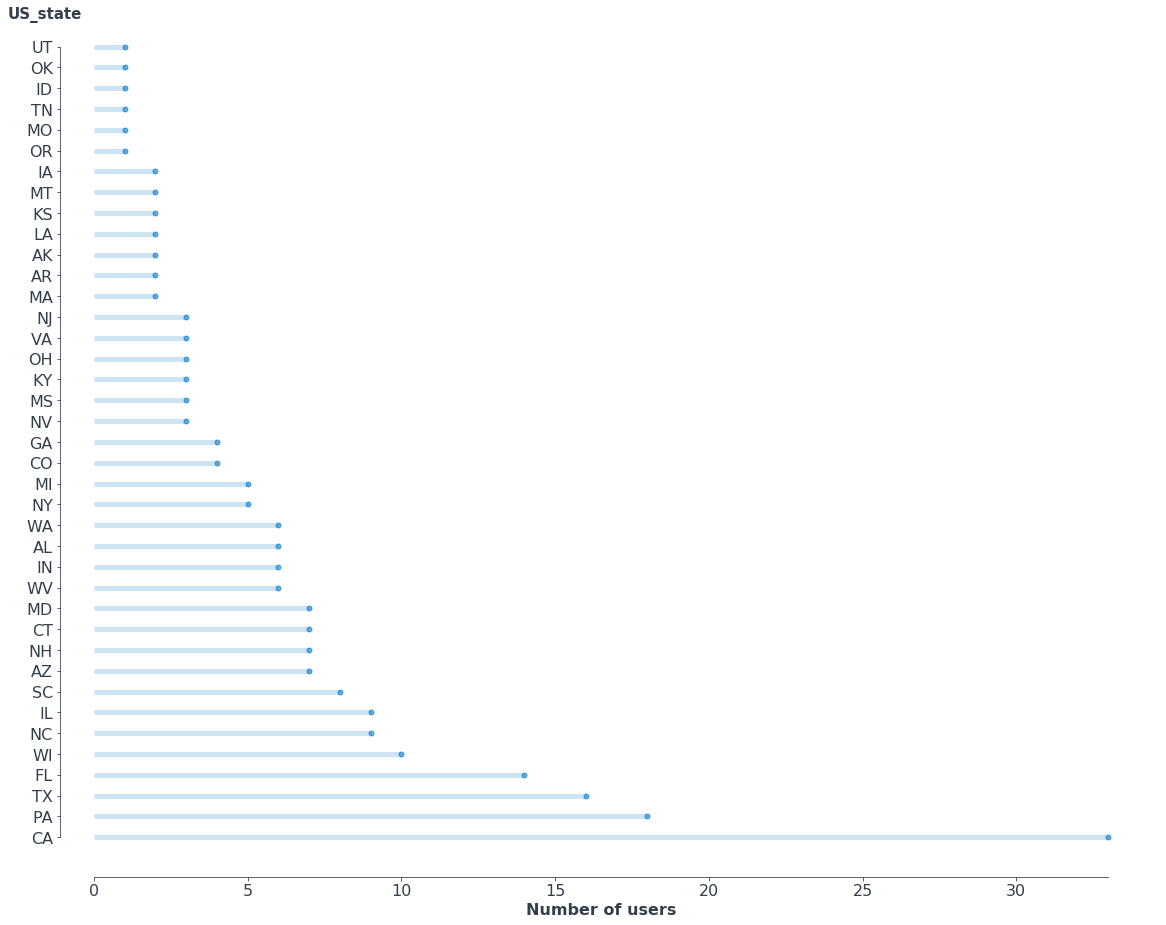

In [88]:
"""
Making bar plots beautiful
I've used the code from https://scentellegher.github.io/visualization/2018/10/10/beautiful-bar-plots-matplotlib.html
as a basis for this plot.
"""

# set font
plt.rcParams['font.family'] = 'DeJaVu Sans'
plt.rcParams['font.sans-serif'] = 'Helvetica'

# set the style of the axes and the text color
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['text.color']='#333F4B'

# we first need a numeric placeholder for the y axis
my_range=list(range(1,len(users_per_state_pd.index)+1))

fig, ax = plt.subplots(figsize=(10*2,8*2))

# create for each expense type an horizontal line that starts at x = 0 with the length 
# represented by the specific expense percentage value.
plt.hlines(y=my_range, xmin=0, xmax=users_per_state_pd['users'], color='#007ACC', alpha=0.2, linewidth=5)

# create for each expense type a dot at the level of the expense percentage value
plt.plot(users_per_state_pd['users'], my_range, "o", markersize=5, color='#007ACC', alpha=0.6)

# set labels
ax.set_xlabel('Number of users', fontsize=16, fontweight='black', color = '#333F4B')
ax.set_ylabel('')

# set axis
ax.tick_params(axis='both', which='major', labelsize=16)
plt.yticks(my_range, users_per_state_pd['US_state'])

# add an horizonal label for the y axis 
fig.text(0.1, 0.87, 'US_state', fontsize=15, fontweight='black', color = '#333F4B')

# change the style of the axis spines
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)

# set the spines position
ax.spines['bottom'].set_position(('axes', -0.0))
ax.spines['left'].set_position(('axes', 0.015))
# plt.savefig(r'C:\Users\hnbez\Documents\GitHub\Portfolio_under_construction\Sparkify/Users_per_state.png',bbox_inches="tight")

#### Making combined data to Pandas

In [89]:
all_data_pd = all_data.toPandas()

In [90]:
all_data_pd

,label,gender,level,downgraded,playlist_add,num_sessions,sum_length,num_songs,num_days,num_errors,num_helps,num_logouts,num_rolladvert,num_savesettings,num_thumbsdown,num_thumbsup,upgraded,num_status404,friends_added
0,0,0,1,0,0.114286,6.771429,1342.983942,5.528571,70,0.000000,0.028571,0.071429,0.166667,0.000000,0.130435,0.300000,1,0.000000,0.095238
1,0,0,0,0,0.071429,2.753425,521.014892,2.054795,73,0.023256,0.027778,0.042857,0.228571,0.014286,0.045455,0.095890,0,0.023256,0.045455
2,0,1,1,0,1.000000,41.750000,8282.470496,34.166667,24,0.125000,0.375000,0.583333,2.000000,0.000000,0.130435,2.416667,1,0.125000,0.458333
3,0,1,0,0,-1.000000,4.916667,860.834330,3.500000,24,0.000000,0.142857,0.285714,0.416667,0.000000,0.000000,0.458333,0,0.000000,0.428571
4,0,1,1,0,0.567164,34.388060,7210.729908,28.776119,67,0.044776,0.238806,0.507463,0.033898,0.061538,0.253731,1.432836,1,0.044776,0.611940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,1,1,1,1,0.260274,14.575342,2940.007184,11.876712,73,0.029851,0.088235,0.150685,0.287671,0.014925,0.123288,0.575342,2,0.029851,0.185714
187,1,0,0,0,0.147727,3.965909,693.465386,2.931818,88,0.017544,0.017544,0.100000,0.250000,0.016949,0.126582,0.126582,0,0.017544,0.033898
188,1,0,1,0,0.916667,25.750000,5075.079599,20.687500,16,0.062500,0.166667,0.416667,0.166667,0.142857,0.583333,0.437500,1,0.062500,0.687500
189,1,1,1,0,0.422535,21.154930,4235.466909,17.281690,71,0.017544,0.056338,0.294118,0.161765,0.028571,0.492958,0.774648,1,0.017544,0.279412


**From the above correlation matrix, we can see that there are highly correlated features.**

#### Removing Multicollinearity

In [91]:
data_dropped = all_data_pd.loc[:, ~all_data_pd.columns.isin(['num_songs','num_sessions','num_status404','sum_length','num_logouts','playlist_add','friends_added'])] 
#I remove the features above due to VIF values above 10. I do not drop the num_thumbsup or num_helps, because there is no logic correlation between them.

vif = pd.DataFrame()
vif["Features"] = data_dropped.columns
vif["VIF"] = [variance_inflation_factor(data_dropped.values, i) for i in range(data_dropped.shape[1])]

vif

,Features,VIF
0,label,1.368020
1,gender,1.893262
2,level,5.923552
3,downgraded,2.545907
4,num_days,3.391992
5,num_errors,2.193381
6,num_helps,10.539104
7,num_rolladvert,2.938249
8,num_savesettings,1.509329
9,num_thumbsdown,5.423646


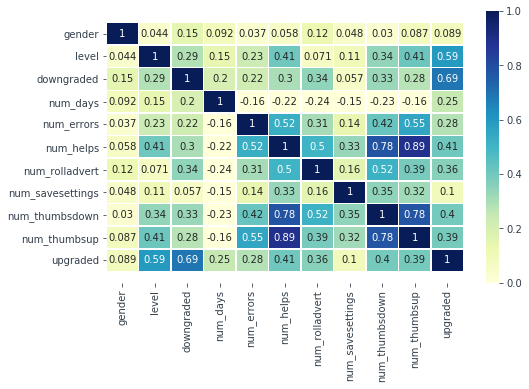

In [92]:
plt.figure(figsize=(8, 5))
sns.heatmap(data_dropped.loc[:,(data_dropped.columns != 'label')].corr(), annot=True, vmin=0, vmax=1, linewidths=.5, cmap="YlGnBu")

# The lines below is to fix a bug with the integration of sns and matplotlib (it was cutting the bottom and top row.)
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.show() 


In [93]:
data_dropped.groupby('label').mean()

,gender,level,downgraded,num_days,num_errors,num_helps,num_rolladvert,num_savesettings,num_thumbsdown,num_thumbsup,upgraded
label,,,,,,,,,,,
0,0.483221,0.731544,0.315436,84.946309,0.023096,0.091580,0.255217,0.023136,0.147473,0.714337,0.751678
1,0.333333,0.690476,0.119048,57.142857,0.015108,0.111846,0.341094,0.034064,0.227181,0.797961,0.595238


In [94]:
label_0_mean = data_dropped.groupby('label').mean().iloc[0,:]
label_1_mean = data_dropped.groupby('label').mean().iloc[1,:]

label_0_median = data_dropped.groupby('label').median().iloc[0,:]
label_1_median = data_dropped.groupby('label').median().iloc[1,:]

label_0_sum = data_dropped.groupby('label').sum().iloc[0,:]
label_1_sum = data_dropped.groupby('label').sum().iloc[1,:]

In [95]:
mean_churn_ratio = label_1_mean / label_0_mean * 100 - 100
mean_churn_ratio = mean_churn_ratio.sort_values()
mean_churn_ratio

downgraded         -62.259372
num_errors         -34.584783
num_days           -32.730618
gender             -31.018519
upgraded           -20.812075
level               -5.613805
num_thumbsup        11.706516
num_helps           22.128886
num_rolladvert      33.648720
num_savesettings    47.229008
num_thumbsdown      54.049896
dtype: float64

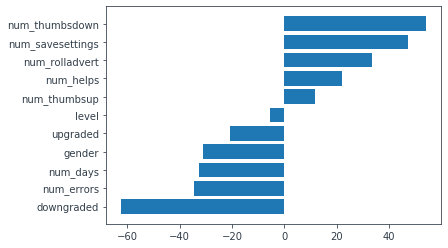

In [96]:
fig, ax = plt.subplots()

y = mean_churn_ratio.index
y_pos = np.arange(len(mean_churn_ratio))

ax.barh(y_pos, mean_churn_ratio.values);
ax.set_yticks(y_pos);
ax.set_yticklabels(y);

#### Checking for outliers

First we separate the features that are normalized by "days as an user"

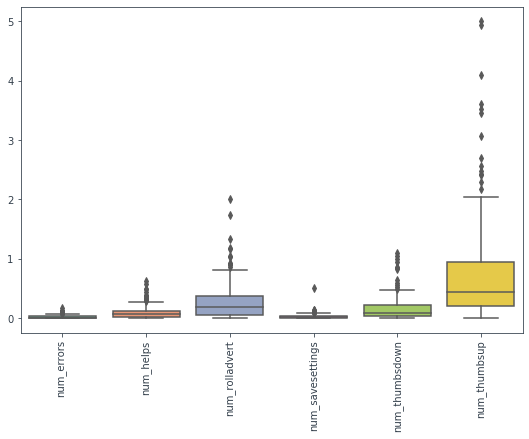

In [97]:
plt.figure(figsize=(9, 6))
sns.boxplot(data=data_dropped.loc[:,(data_dropped.columns != 'num_days') & 
                                  (data_dropped.columns != 'label') & 
                                  (data_dropped.columns != 'gender') & 
                                  (data_dropped.columns != 'level') &
                                  (data_dropped.columns != 'downgraded') &
                                  (data_dropped.columns != 'upgraded')], 
            palette="Set2")
plt.xticks(rotation=90);

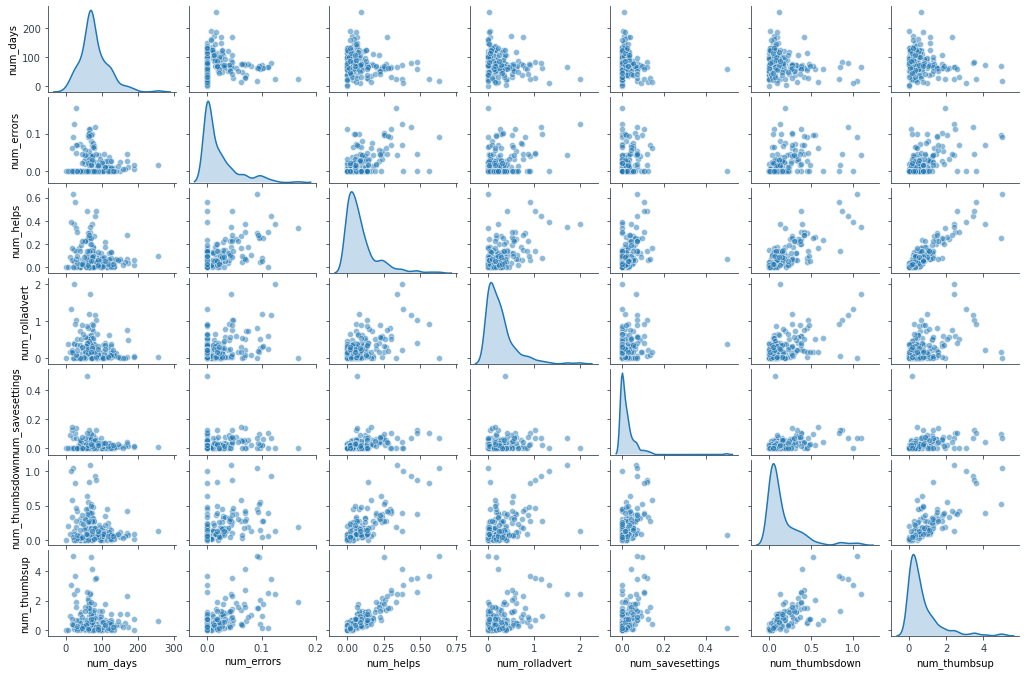

In [98]:
pairplot = sns.pairplot(data_dropped.loc[:,(data_dropped.columns != 'label') & 
                                         (data_dropped.columns != 'gender') & 
                                         (data_dropped.columns != 'level') &
                                         (data_dropped.columns != 'downgraded') &
                                         (data_dropped.columns != 'upgraded')], 
                        diag_kind='kde', plot_kws={'alpha':0.5})
pairplot.fig.set_size_inches(14, 9)
plt.yticks(rotation=90);

**Checking number of outliers**

In [99]:
Q1 = data_dropped.loc[:, ~data_dropped.columns.isin(['label','gender','level','downgraded','upgraded'])].quantile(0.25)
Q3 = data_dropped.loc[:, ~data_dropped.columns.isin(['label','gender','level','downgraded','upgraded'])].quantile(0.75)
IQR = Q3-Q1
step = 1.5 * IQR

len_without_outliers = data_dropped[~((data_dropped.loc[:, ~data_dropped.columns.isin(['label','gender','level','downgraded','upgraded'])] < (Q1 - 1.5 * IQR)) | 
                                               (data_dropped.loc[:, ~data_dropped.columns.isin(['label','gender','level','downgraded','upgraded'])] > (Q3 + 1.5 * IQR))).any(axis=1)].shape[0]

print('The total amount of users that do not have features as outliers is {}, out of {}.'.format(len_without_outliers, len(data_dropped)))

The total amount of users that do not have features as outliers is 146, out of 191.


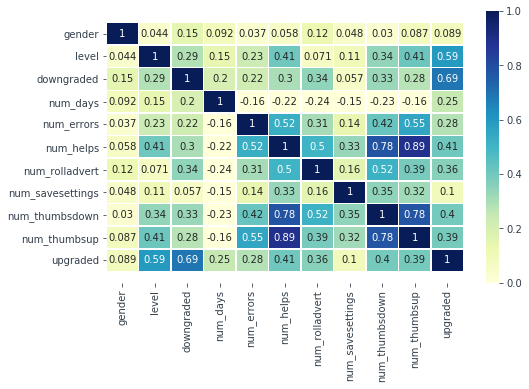

In [100]:
plt.figure(figsize=(8, 5))
sns.heatmap(data_dropped.loc[:,(data_dropped.columns != 'label')].corr(), 
            annot=True, 
            vmin=0, 
            vmax=1, 
            linewidths=.5, 
            cmap="YlGnBu")

# The lines below is to fix a bug with the integration of sns and matplotlib (it was cutting the bottom and top row.)
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.show() 


**I tried applying log, log(x+1) transformations, boxcox and boxcox1p in order to solve skewness, without success due to inf issues, or because it remained skewed. Below I try square root transformation.**

In [101]:
sqrt_data_dropped = data_dropped.apply(lambda x: np.sqrt(x) if x.name in ['num_days', 'num_errors', 'num_helps', 'num_rolladvert',
                                                                        'num_savesettings', 'num_thumbsdown', 'num_thumbsup'] else x)

In [102]:
sqrt_data_dropped.skew()

label               1.363320
gender              0.201531
level              -1.001782
downgraded          2.356137
num_days           -0.226059
num_errors          0.701003
num_helps           0.481128
num_rolladvert      0.513463
num_savesettings    1.060939
num_thumbsdown      0.805853
num_thumbsup        0.961648
upgraded            1.349739
dtype: float64

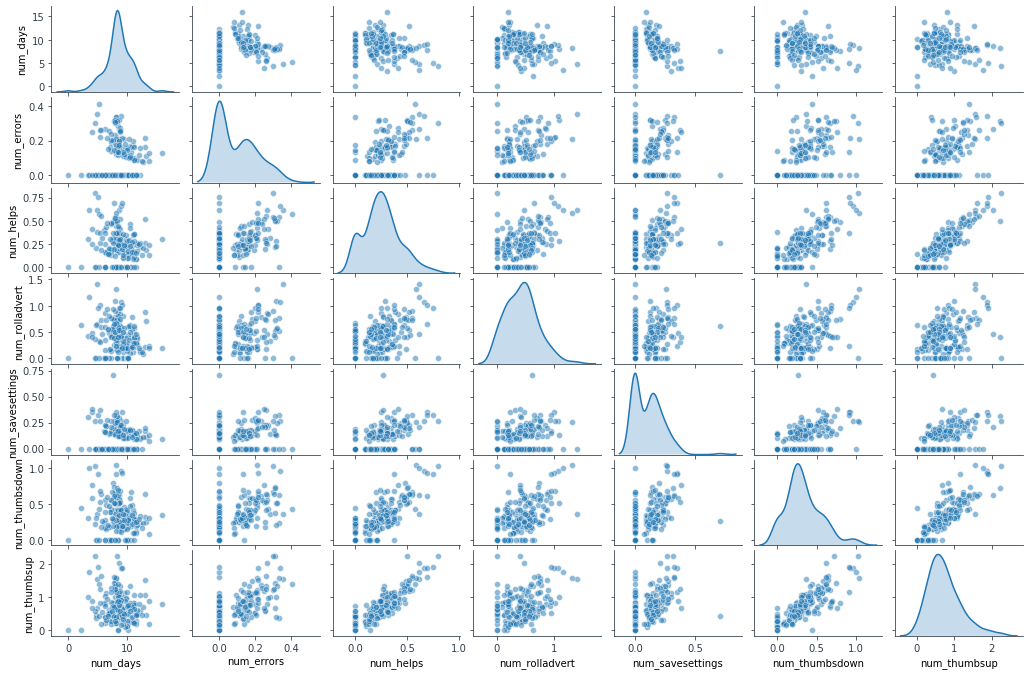

In [104]:
pairplot = sns.pairplot(sqrt_data_dropped.loc[:,(sqrt_data_dropped.columns != 'label') &
                                              (sqrt_data_dropped.columns != 'gender') & 
                                              (sqrt_data_dropped.columns != 'level') &
                                              (sqrt_data_dropped.columns != 'downgraded') &
                                              (sqrt_data_dropped.columns != 'upgraded')], 
                        diag_kind='kde', plot_kws={'alpha':0.5})
pairplot.fig.set_size_inches(14, 9)


In [105]:
sqrt_data_dropped.describe()

,label,gender,level,downgraded,num_days,num_errors,num_helps,num_rolladvert,num_savesettings,num_thumbsdown,num_thumbsup,upgraded
count,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000
mean,0.219895,0.450262,0.722513,0.272251,8.599708,0.097308,0.256926,0.441315,0.111107,0.338041,0.737013,0.717277
std,0.415264,0.498828,0.448936,0.588678,2.214306,0.109239,0.173735,0.282417,0.115170,0.225822,0.436503,0.749502
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,7.681146,0.000000,0.150201,0.209609,0.000000,0.197961,0.448828,0.000000
50%,0.000000,0.000000,1.000000,0.000000,8.485281,0.082199,0.250000,0.436436,0.115470,0.297044,0.664726,1.000000
75%,0.000000,1.000000,1.000000,0.000000,9.974937,0.171512,0.351740,0.601784,0.182574,0.465559,0.972962,1.000000
max,1.000000,1.000000,1.000000,3.000000,16.000000,0.408248,0.794719,1.414214,0.707107,1.043816,2.236068,4.000000


**We see that sqrt transformation improves nicely the skewness, so I'll use it.**

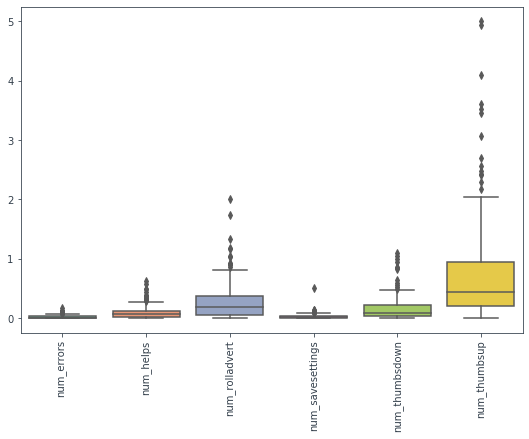

In [106]:
plt.figure(figsize=(9, 6))
sns.boxplot(data=data_dropped.loc[:,(sqrt_data_dropped.columns != 'label') & 
                                  (sqrt_data_dropped.columns != 'num_days') & 
                                  (sqrt_data_dropped.columns != 'gender') & 
                                  (sqrt_data_dropped.columns != 'level') &
                                  (sqrt_data_dropped.columns != 'downgraded') &
                                  (sqrt_data_dropped.columns != 'upgraded')], 
                 palette="Set2")
plt.xticks(rotation=90);

In [107]:
Q1 = sqrt_data_dropped.loc[:, ~data_dropped.columns.isin(['label','gender','level','downgraded','upgraded'])].quantile(0.25)
Q3 = sqrt_data_dropped.loc[:, ~data_dropped.columns.isin(['label','gender','level','downgraded','upgraded'])].quantile(0.75)
IQR = Q3-Q1
step = 1.5 * IQR

len_without_outliers = sqrt_data_dropped[~((sqrt_data_dropped.loc[:, ~sqrt_data_dropped.columns.isin(['label','gender','level','downgraded','upgraded'])] < (Q1 - 1.5 * IQR)) | 
                                           (sqrt_data_dropped.loc[:, ~sqrt_data_dropped.columns.isin(['label','gender','level','downgraded','upgraded'])] > (Q3 + 1.5 * IQR))).any(axis=1)].shape[0]

print('The total amount of users that do not have features as outliers is {}, out of {}.'.format(len_without_outliers, len(data_dropped)))

The total amount of users that do not have features as outliers is 171, out of 191.


In [108]:
sqrt_data_dropped_2 = sqrt_data_dropped[~((sqrt_data_dropped.loc[:, ~sqrt_data_dropped.columns.isin(['label','gender','level','downgraded','upgraded'])] < (Q1 - 1.5 * IQR)) | 
                                           (sqrt_data_dropped.loc[:, ~sqrt_data_dropped.columns.isin(['label','gender','level','downgraded','upgraded'])] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [109]:
sqrt_data_dropped_2.describe()

,label,gender,level,downgraded,num_days,num_errors,num_helps,num_rolladvert,num_savesettings,num_thumbsdown,num_thumbsup,upgraded
count,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000
mean,0.192982,0.444444,0.719298,0.263158,8.776716,0.092851,0.235446,0.423457,0.096710,0.306223,0.679407,0.707602
std,0.395798,0.498363,0.450662,0.559190,1.821025,0.105609,0.150147,0.256312,0.096684,0.186986,0.349120,0.708686
min,0.000000,0.000000,0.000000,0.000000,4.582576,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,7.842129,0.000000,0.143597,0.207614,0.000000,0.187592,0.442131,0.000000
50%,0.000000,0.000000,1.000000,0.000000,8.602325,0.078326,0.239046,0.434372,0.106600,0.280449,0.643650,1.000000
75%,0.000000,1.000000,1.000000,0.000000,10.024938,0.167251,0.328282,0.585782,0.169031,0.415227,0.886689,1.000000
max,1.000000,1.000000,1.000000,3.000000,13.152946,0.408248,0.577350,1.086429,0.369274,0.800000,1.643168,4.000000


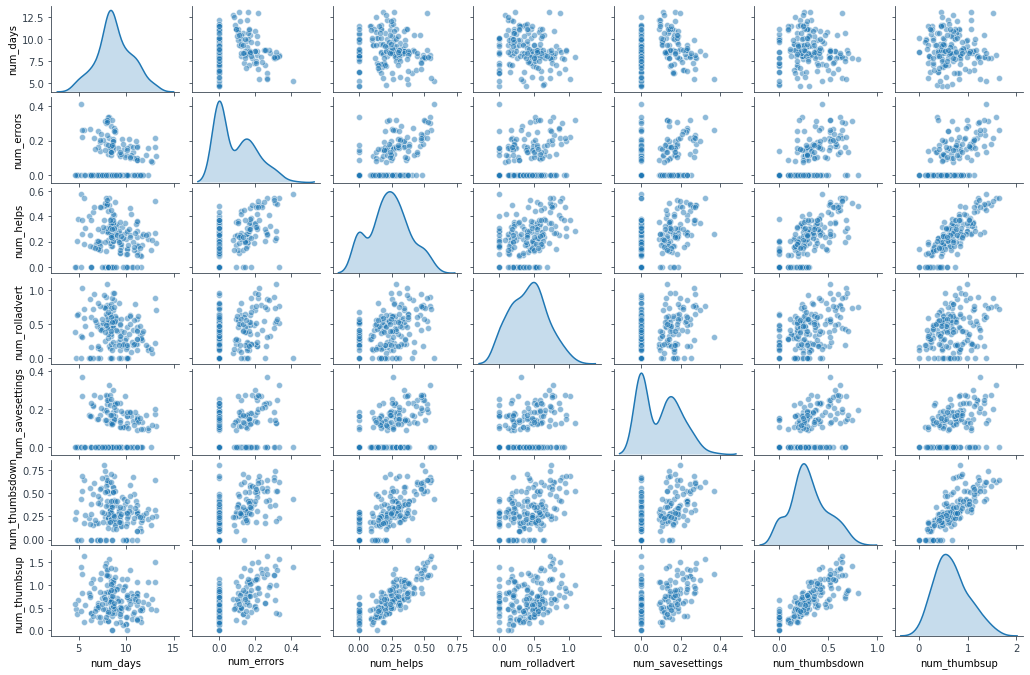

In [110]:
pairplot = sns.pairplot(sqrt_data_dropped_2.loc[:,(sqrt_data_dropped_2.columns != 'label') &
                                                (sqrt_data_dropped_2.columns != 'gender') &
                                                (sqrt_data_dropped_2.columns != 'level') &
                                                (sqrt_data_dropped_2.columns != 'downgraded') &
                                                (sqrt_data_dropped_2.columns != 'upgraded')], 
                        diag_kind='kde', plot_kws={'alpha':0.5})
pairplot.fig.set_size_inches(14, 9)

In [111]:
sqrt_data_dropped_2.loc[:,(sqrt_data_dropped_2.columns != 'label') &
                                                (sqrt_data_dropped_2.columns != 'gender') &
                                                (sqrt_data_dropped_2.columns != 'level') &
                                                (sqrt_data_dropped_2.columns != 'downgraded') &
                                                (sqrt_data_dropped_2.columns != 'upgraded')].skew()

num_days            0.087435
num_errors          0.726776
num_helps           0.094393
num_rolladvert      0.155579
num_savesettings    0.407444
num_thumbsdown      0.337376
num_thumbsup        0.488627
dtype: float64

**now we see that the skewness decreased a lot**